In [2]:
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import timedelta
plt.style.use('seaborn')
%matplotlib inline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

## Remove warning label that would be shown with some graphs. 
## Some libraries do not like some operations, but the operations yields correct results
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Analysis of Cycling Data

## Loading Data

The first dataset is an export of my ride data from [Strava](https://strava.com/), an online social 
network site for cycling and other sports.  This data is a log of every ride since the start of 2018
and contains summary data like the distance and average speed.  It was exported using 
the script `stravaget.py` which uses the stravalib module to read data. Some details of
the fields exported by that script can be seen in [the documentation for stravalib](https://pythonhosted.org/stravalib/api.html#stravalib.model.Activity). 

The exported data is a CSV file so that's easy to read, however the date information in the file is 
recorded in a different timezone (UTC) so we need to do a bit of conversion.  In reading the data I'm
setting the index of the data frame to be the datetime of the ride. 

In [3]:
strava = pd.read_csv('data/strava_export.csv', index_col='date', parse_dates=True)
strava.index = strava.index.tz_convert('UTC')
strava.head()

,average_heartrate,average_temp,average_watts,device_watts,distance,elapsed_time,elevation_gain,kudos,moving_time,workout_type
date,,,,,,,,,,
2018-01-02 20:47:51+00:00,100.6,21.0,73.8,False,15.2,94,316.00 m,10,73,Ride
2018-01-04 01:36:53+00:00,NaN,24.0,131.7,False,18.0,52,236.00 m,5,46,Ride
2018-01-04 02:56:00+00:00,83.1,25.0,13.8,False,0.0,3,0.00 m,2,2,Ride
2018-01-04 05:37:04+00:00,110.1,24.0,113.6,False,22.9,77,246.00 m,8,64,Ride
2018-01-05 19:22:46+00:00,110.9,20.0,147.7,True,58.4,189,676.00 m,12,144,Ride


The second dataset comes from an application called [GoldenCheetah](https://www.goldencheetah.org/) which provides
some analytics services over ride data.  This has some of the same fields but adds a lot of analysis of the 
power, speed and heart rate data in each ride.  This data overlaps with the Strava data but doesn't include all 
of the same rides. 

Again we create an index using the datetime for each ride, this time combining two columns in the data (date and time) 
and localising to Sydney so that the times match those for the Strava data. 

In [4]:
cheetah = pd.read_csv('data/cheetah.csv', skipinitialspace=True)
cheetah.index = pd.to_datetime(cheetah['date'] + ' ' + cheetah['time'])
cheetah.index = cheetah.index.tz_localize('Australia/Sydney')
cheetah.head()

,date,time,filename,axPower,aPower Relative Intensity,aBikeScore,Skiba aVI,aPower Response Index,aIsoPower,aIF,...,Rest AVNN,Rest SDNN,Rest rMSSD,Rest PNN50,Rest LF,Rest HF,HRV Recovery Points,NP,IF,TSS
2018-01-28 06:39:49+11:00,01/28/18,06:39:49,2018_01_28_06_39_49.json,202.211,0.75452,16.6520,1.31920,1.67755,223.621,0.83441,...,0,0,0,0,0,0,0,222.856,0.83155,20.2257
2018-01-28 07:01:32+11:00,01/28/18,07:01:32,2018_01_28_07_01_32.json,226.039,0.84343,80.2669,1.21137,1.54250,246.185,0.91860,...,0,0,0,0,0,0,0,245.365,0.91554,94.5787
2018-02-01 08:13:34+11:00,02/01/18,08:13:34,2018_02_01_08_13_34.json,0.000,0.00000,0.0000,0.00000,0.00000,0.000,0.00000,...,0,0,0,0,0,0,0,0.000,0.00000,0.0000
2018-02-06 08:06:42+11:00,02/06/18,08:06:42,2018_02_06_08_06_42.json,221.672,0.82714,78.8866,1.35775,1.86002,254.409,0.94929,...,0,0,0,0,0,0,0,253.702,0.94665,98.3269
2018-02-07 17:59:05+11:00,02/07/18,17:59:05,2018_02_07_17_59_05.json,218.211,0.81422,159.4590,1.47188,1.74658,233.780,0.87231,...,0,0,0,0,0,0,0,232.644,0.86808,171.0780


The GoldenCheetah data contains many many variables (columns) and I won't go into all of them here. Some
that are of particular interest for the analysis below are:

Here are definitions of some of the more important fields in the data. Capitalised fields come from the GoldenCheetah data
while lowercase_fields come from Strava. There are many cases where fields are duplicated and in this case the values
should be the same, although there is room for variation as the algorithm used to calculate them could be different
in each case. 

  * Duration - overall duration of the ride, should be same as elapsed_time
  * Time Moving - time spent moving (not resting or waiting at lights), should be the same as moving_time
  * Elevation Gain - metres climbed over the ride
  * Average Speed - over the ride
  * Average Power - average power in watts as measured by a power meter, relates to how much effort is being put in to the ride, should be the same as  * average_watts' from Strava
  * Nonzero Average Power - same as Average Power but excludes times when power is zero from the average
  * Average Heart Rate - should be the same as average_heartrate
  * Average Cadence - cadence is the rotations per minute of the pedals
  * Average Temp - temperature in the environment as measured by the bike computer (should be same as average_temp)
  * VAM - average ascent speed - speed up hills
  * Calories (HR) - Calorie expendature as estimated from heart rate data
  * 1 sec Peak Power - this and other  'Peak Power' measures give the maximum power output in the ride over this time period.  Will be higher for shorter periods. High values in short periods would come from a very 'punchy' ride with sprints for example.
  * 1 min Peak Hr - a similar measure relating to Heart Rate
  * NP - Normalised Power, a smoothed average power measurement, generally higher than Average Power 
  * TSS - Training Stress Score, a measure of how hard a ride this was
  * device_watts - True if the power (watts) measures were from a power meter, False if they were estimated
  * distance - distance travelled in Km
  * kudos - likes from other Strava users (social network)
  * workout_type - one of  'Race',  'Workout' or  'Ride'
  
  
Some of the GoldenCheetah parameters are defined [in thier documentation](https://github.com/GoldenCheetah/GoldenCheetah/wiki/UG_Glossary).

## Combining data sets

The first task is to combine these two data frames using the [`join` method of Pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html#joining-on-index).   The goal is to keep only those rows of data 
that appear in __both__ data frames so that we have complete data for every row.  

In [5]:
df = strava.join(cheetah,how='inner')
df.head()

,average_heartrate,average_temp,average_watts,device_watts,distance,elapsed_time,elevation_gain,kudos,moving_time,workout_type,...,Rest AVNN,Rest SDNN,Rest rMSSD,Rest PNN50,Rest LF,Rest HF,HRV Recovery Points,NP,IF,TSS
2018-01-27 19:39:49+00:00,120.6,21.0,153.4,True,7.6,17,95.00 m,4,17,Ride,...,0,0,0,0,0,0,0,222.856,0.83155,20.2257
2018-01-27 20:01:32+00:00,146.9,22.0,187.7,True,38.6,67,449.00 m,19,67,Race,...,0,0,0,0,0,0,0,245.365,0.91554,94.5787
2018-01-31 21:13:34+00:00,109.8,19.0,143.0,False,26.3,649,612.00 m,6,113,Ride,...,0,0,0,0,0,0,0,0.000,0.00000,0.0000
2018-02-05 21:06:42+00:00,119.3,19.0,165.9,True,24.3,69,439.00 m,6,65,Ride,...,0,0,0,0,0,0,0,253.702,0.94665,98.3269
2018-02-07 06:59:05+00:00,124.8,20.0,151.0,True,47.1,144,890.00 m,10,134,Ride,...,0,0,0,0,0,0,0,232.644,0.86808,171.0780


# Cleaning Data

The first thing to do is to clean the data, so that we have a proper analysis. It doesn't make sense to drop rows of data just because it has a NaN or null value, when the rest of the row can have every other data entry.

In [6]:
Cleaning_df = len(df) - df.count()
Cleaning_df

average_heartrate      29
average_temp           58
average_watts          10
device_watts            4
distance                0
                       ..
Rest HF                 0
HRV Recovery Points     0
NP                      0
IF                      0
TSS                     0
Length: 372, dtype: int64

We can see that there are 4 attributes with missing values, lets look at this more closely. 

As shown below, device watts and average watts is not that much of a concern, as they both only make up less than 5% of the missing data and can be easily filled in via using the average of their respective columns. However, average heart rate and temp are of a little more concern, as there is 12% and 24% missing values in relation to the entire data frame. Average heart rate can be filled in with the average of the column, as there is sufficient data to extrapolate. Average_temp is not crucial in this analysis and can also be filled in with the mean.

In [7]:
Cleaning_df2 = Cleaning_df[['average_heartrate', 'average_temp', 'average_watts', 'device_watts']]
print(Cleaning_df2/df.shape[0]*100)

average_heartrate    11.934156
average_temp         23.868313
average_watts         4.115226
device_watts          1.646091
dtype: float64


In [8]:
df['device_watts'].fillna((df['device_watts'].mean()), inplace=True)
df['average_watts'].fillna((df['average_watts'].mean()), inplace=True)
df['average_watts'].fillna((df['average_heartrate'].mean()), inplace=True)
df['average_watts'].fillna((df['average_temp'].mean()), inplace=True)

# Initial Analysis
After cleaning the data, we must now remove data entries where device_watts is false, because this would include commutes and MTB rides. Next, we have to check the distribution of some of the key variables to see what we can expect from each chosen variable. It is important to note that the y axis on the following graphs displays the probability of density function for each kernel and its estimation of density.

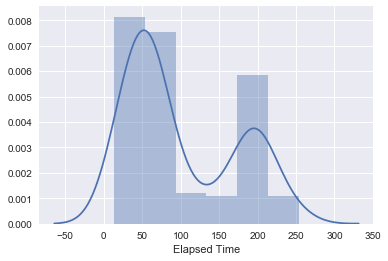

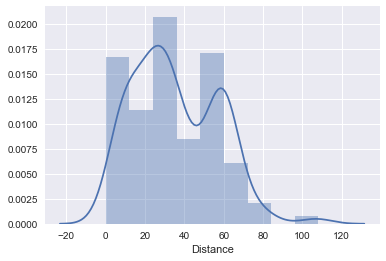

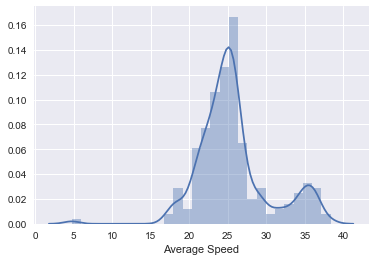

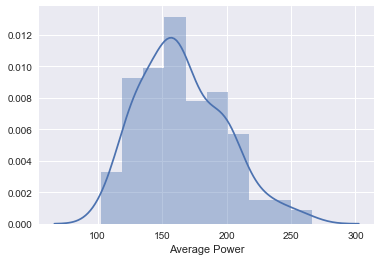

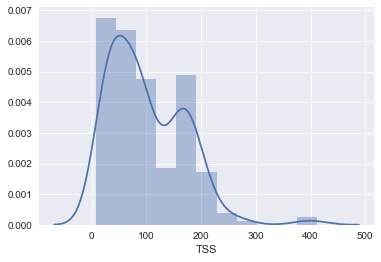

In [11]:
# Removing rides with no power, these would be commutes or non-applicable 
df = df[df['device_watts'] == True]

# Making separate data frames for key variables to judge distribution
dfElapsedTime = df[['elapsed_time']]
sns.distplot(dfElapsedTime).set(xlabel='Elapsed Time')

plt.figure()
dfDistance = df[['distance']]
sns.distplot(dfDistance).set(xlabel='Distance')

plt.figure()
dfDistance = df[['Average Speed']]
sns.distplot(dfDistance).set(xlabel='Average Speed')

plt.figure()
dfDistance = df[['Average Power']]
sns.distplot(dfDistance).set(xlabel='Average Power')

plt.figure()
dfDistance = df[['TSS']]
sns.distplot(dfDistance).set(xlabel='TSS')

plt.show()

### Distribution of variables
* **Time**: This graph shows a clear bimodal distribution with a slight right skew evident.
* **Distance**: With a large amount of data being centralised to two peaks, a biomodal distribution can be seen, there is also an evident rigth skew.
* **Average speed**: This graph is a similar shape to a normal distribution but due to a spike in the data at around 35 KM/hr, the graph is actually bimodal. 
* **Average power**: This data is clearly right skewed, because of the large amount of data lies at the beginning of the graph.
* **TSS**: This data subset contains two significantly high peaks therefore it is a bimodal distribution and due to the outlying data at 400 it is right skewed.

# Relationships and correlations between key variables

The next step in this analysis is to explore the relationships between the following variables. 
Are any of them corrolated with each other (do they vary together in a predictable way)? 
Can we explain any relationships we observe?
 * Distance
 * Moving Time
 * Average Speed
 * Heart Rate
 * Power (watts)
 * Normalised power (NP)
 * Training Stress Score
 * Elevation Gain

In [9]:
#Create a second dataframe for key variables
df2 = df[['distance','moving_time','Average Speed','average_heartrate', 'average_watts', 'NP', 'TSS', 'Elevation Gain']]
df2.corr()

,distance,moving_time,Average Speed,average_heartrate,average_watts,NP,TSS,Elevation Gain
distance,1.000000,0.972260,0.110461,0.078131,0.031858,0.202935,0.920085,0.804821
moving_time,0.972260,1.000000,-0.100980,-0.079929,-0.112507,0.092046,0.909389,0.826645
Average Speed,0.110461,-0.100980,1.000000,0.726858,0.720608,0.507974,0.037499,-0.078419
average_heartrate,0.078131,-0.079929,0.726858,1.000000,0.672457,0.578104,0.080077,0.047363
average_watts,0.031858,-0.112507,0.720608,0.672457,1.000000,0.772574,0.150163,-0.100030
NP,0.202935,0.092046,0.507974,0.578104,0.772574,1.000000,0.425102,0.228622
TSS,0.920085,0.909389,0.037499,0.080077,0.150163,0.425102,1.000000,0.830574
Elevation Gain,0.804821,0.826645,-0.078419,0.047363,-0.100030,0.228622,0.830574,1.000000


### Correlation between key variables (Correlation >0.80)


By examining the correlation matrix shown, some key correlations can be observed, which are:
- **Distance and Moving time**: This is an obvious correlation and is very predictable, as it is intuitive that as distance increases, so would moving time.
- **Distance and TSS**: This correlation is more interesting than the former, to a certain extent. The Training stress score (difficulty of the ride) has a strong linear correlation (indicating it is quite predictable), illustrating that as the ride becomes longer in length, so does the difficulty in it, which makes sense physiologically, as muscular fatigue sets in and the cardiovascular system is under intense strain. 
- **Moving time and TSS**: The correlation between these two variables is quite predictable, since Distance and moving time are already correlated, it makes sense that moving time and TSS are correlated, as moving time increases, TSS should also increase, due to the physiological responses.
- **Distance and Elevation Gain**: Correlation in this instance is often dependent on the area ridden. This can be seen, for example, in the normal route which may involve hills and in turn a large amount of both ascent and descent. However if a different route is taken that is more flat and has only subtle changes in elevation there will be less correlation. The variables here show a high level of correlation therefore it can be assumed that the area ridden is precipitous.
- **Moving time and Elevation Gain**: Since distance and moving time are already strongly correlated in conjunction with distance and elevation gain being correlated, it only makes sense that moving time and elevation gain would be correlated, as when the ride progresses, hills or slopes would be encountered.
- **TSS and Elevation Gain**: The correlation between these two variables are of a slightly more interesting note, suggesting that as elevation gain increases, the training stress would also increase, as a result of the increasing angle of travel; suggesting that cycles were undertaken in mountainous areas. 

# Exploration of the different work out types

The next stage in this analysis is going to be exploring the differences between the three categories: `Race`, `Workout` and `Ride`.

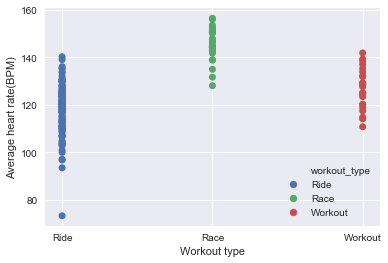

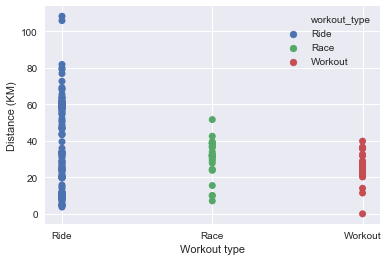

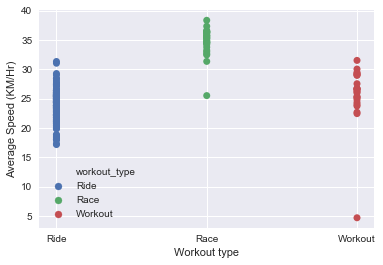

In [10]:
#4
plt.tight_layout()

sns.scatterplot(x="workout_type", y="average_heartrate", data=df, hue = 'workout_type', linewidth = 0).set(
    ylabel='Average heart rate(BPM)', 
    xlabel='Workout type')

plt.figure()
sns.scatterplot(x="workout_type", y="distance", data=df, hue = 'workout_type', linewidth = 0).set(
    ylabel='Distance (KM)', 
    xlabel='Workout type')

plt.figure()
sns.scatterplot(x="workout_type", y="Average Speed", data=df, hue = 'workout_type', linewidth = 0).set(
    ylabel='Average Speed (KM/Hr)', 
    xlabel='Workout type')

plt.show()

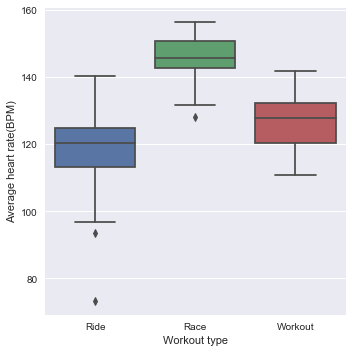

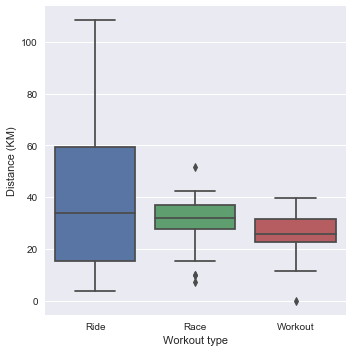

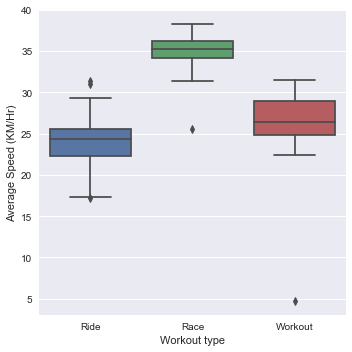

In [11]:
sns.catplot(x="workout_type", y="average_heartrate", data=df, kind="box").set(
    ylabel='Average heart rate(BPM)', 
    xlabel='Workout type')

sns.catplot(x="workout_type", y="Distance", data=df, kind="box").set(
    ylabel='Distance (KM)', 
    xlabel='Workout type')

sns.catplot(x="workout_type", y="Average Speed", data=df, kind="box").set(
    ylabel='Average Speed (KM/Hr)', 
    xlabel='Workout type')

plt.show()

### Relationships to note

  * **Average heart rate** and **workout type** clearly infer that the type of workout dictates the average heart rate. It makes sense for the average heart rate to be higher when an individual is racing as it demands more effort than a normal ride or workout.

  * The relationship between **distance** and **workout type** is of a interesting note. There is a large range and spread when it comes to the ride group, with values exceeding 100km, however the race group is quite concise, with 50% of its data falling between approximately 10km. The race group has a large spread of values, which can be interpreted that there are cases when a cyclist performs worse than the group possibly due to injury or a crash. 
  
  * **Average speed** and **workout type** is not as interesting as the previous two, however, an inference can still be obtained from the data. It can be said that the ride group is clearly slower than the race group, however, the spread is similar to the race group.

# Variables and the relationship between kudos

In [12]:
df3 = df[['distance','moving_time','Average Speed','average_heartrate', 'average_watts', 'NP', 'TSS', 'Elevation Gain', 'kudos']]
df3.corr()

,distance,moving_time,Average Speed,average_heartrate,average_watts,NP,TSS,Elevation Gain,kudos
distance,1.000000,0.972260,0.110461,0.078131,0.031858,0.202935,0.920085,0.804821,0.752259
moving_time,0.972260,1.000000,-0.100980,-0.079929,-0.112507,0.092046,0.909389,0.826645,0.665831
Average Speed,0.110461,-0.100980,1.000000,0.726858,0.720608,0.507974,0.037499,-0.078419,0.394387
average_heartrate,0.078131,-0.079929,0.726858,1.000000,0.672457,0.578104,0.080077,0.047363,0.359824
average_watts,0.031858,-0.112507,0.720608,0.672457,1.000000,0.772574,0.150163,-0.100030,0.245937
NP,0.202935,0.092046,0.507974,0.578104,0.772574,1.000000,0.425102,0.228622,0.384543
TSS,0.920085,0.909389,0.037499,0.080077,0.150163,0.425102,1.000000,0.830574,0.694504
Elevation Gain,0.804821,0.826645,-0.078419,0.047363,-0.100030,0.228622,0.830574,1.000000,0.634021
kudos,0.752259,0.665831,0.394387,0.359824,0.245937,0.384543,0.694504,0.634021,1.000000


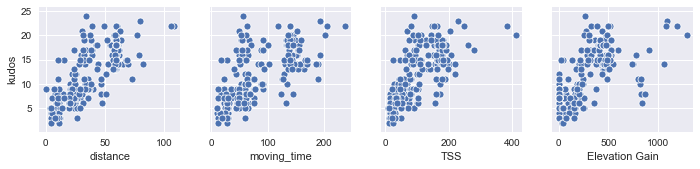

In [13]:
sns.pairplot(data=df3,
                  y_vars=['kudos'],
                  x_vars=['distance', 'moving_time', 'TSS', 'Elevation Gain'])

By examining the correlation matrix with respect to kudos we can see what has the greatest effect when it increases. From our graphs we can determine that distance, moving time, TSS and elevation gain all have a strong impact on increasing kudos. Through further examinination of the scatterplot matrix, it becomes evident that there is a relationship between these four variables and the amount of kudos obtained from them, as shown by the decent linear relationship, as one of the x variables increases, kudos (y variable) is likely to increase as well.
 
The most important variable that is likely to increase kudos is distance. Distance and kudos have a 0.72 correlation factor, this makes sense as a longer ride would yield more kudos, as it can be seen in the graph. The second most important variable is Training Stress Score (TSS), with a correlation of 0.65, this also makes sense, as a harder ride would generally yield more kudos, also shown in the above graph.



 # Overall summary of activity

Second to last, we want to generate an overall summary of activity by overlaying 3 key variables. These variables are Training Stress Score (TSS), Distance and Average Speed. We will explore the overall summary by looking at the monthly sum of TSS and the number of KM ridden. Finally, we will include the average speed for each month 

In [14]:
#Function to add legend 
def addLegend():
    red= mpatches.Patch(color='r', label='TSS')
    green= mpatches.Patch(color='g', label='Average Speed ')
    blue= mpatches.Patch(color='b', label='Distance')
    plt.legend(handles=[red, green, blue])

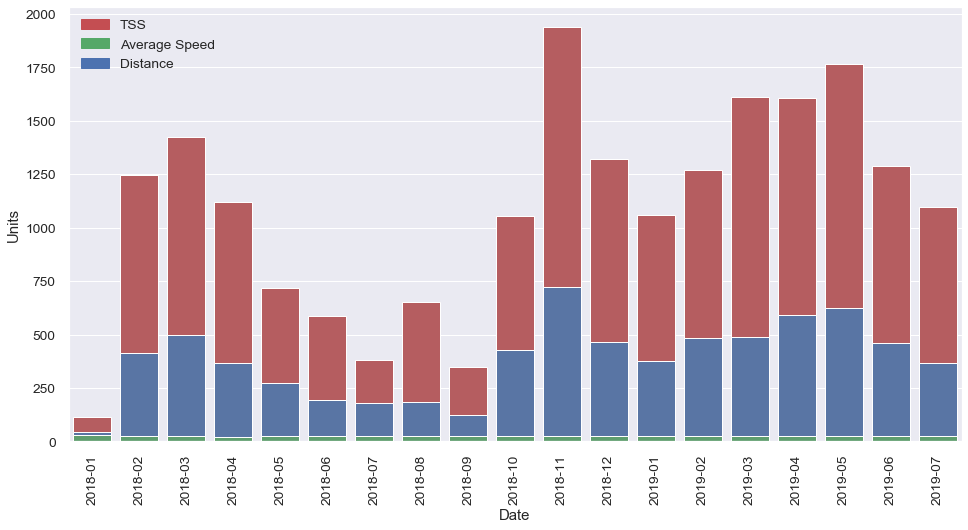

In [15]:
df4 = df2.resample("M").sum()
df4['Time'] = df4.index

df5 = df2.resample("M").mean()
df5['Time'] = df4.index

plt.figure(figsize=(16, 8)), sns.set(font_scale = 1.25)
plt.xticks(rotation=90)

ax2 = sns.barplot(data=df4, x='Time', y = "TSS", color='r')
ax2 = sns.barplot(data=df4, x='Time', y = "distance", color='b')
ax2 = sns.barplot(data=df5, x='Time', y = "Average Speed", color='g').set(
    xticklabels=['2018-01', '2018-02','2018-03','2018-04',
                 '2018-05','2018-06','2018-07','2018-08',
                 '2018-09','2018-10','2018-11','2018-12',
                 '2019-01','2019-02','2019-03','2019-04',
                 '2019-05','2019-06','2019-07'])

plt.xlabel("Date"), plt.ylabel("Units")
addLegend()
plt.show()

We cannot easily make an overall judgement from the above graph, because it is evident that the data from other variables are overwhelmed by the data from TSS. TSS has a very large range compared to average speed which cannot have as large a range due to the nature and limits of road cycling. In this situation we can standardise the data to provide a superior and more interpretable graph.

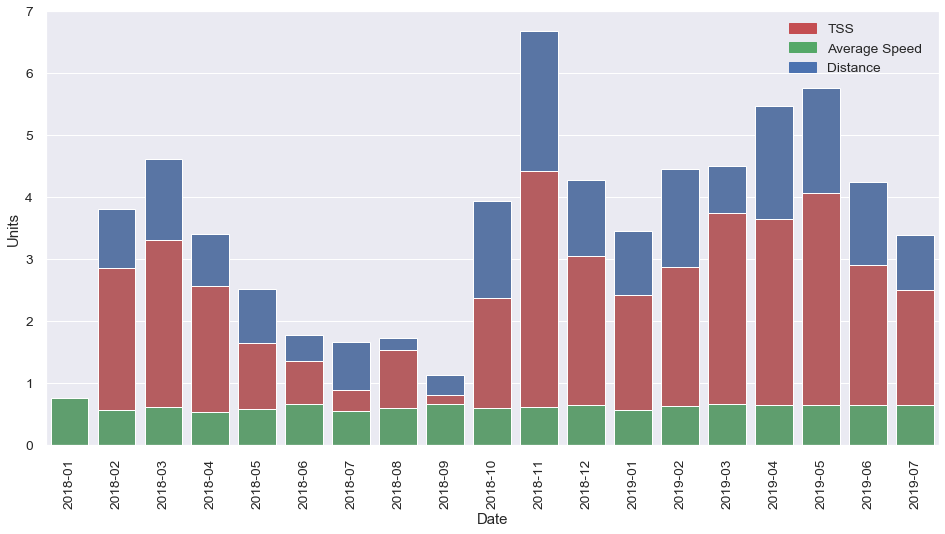

In [16]:
df2_norm = (df2-df2.min())/(df2.max()-df2.min())

df4 = df2_norm.resample("M").sum()
df4['Time'] = df4.index

df5 = df2_norm.resample("M").mean()
df5['Time'] = df5.index

plt.figure(figsize=(16, 8)), sns.set(font_scale = 1.25)
plt.xticks(rotation=90)
ax2 = sns.barplot(data=df4, x='Time', y = "distance", color='b')
ax2 = sns.barplot(data=df4, x='Time', y = "TSS", color='r')
ax2 = sns.barplot(data=df5, x='Time', y = "Average Speed", color='g').set(
        xticklabels=['2018-01', '2018-02', '2018-03', '2018-04', 
                     '2018-05', '2018-06', '2018-07', '2018-08',
                     '2018-09', '2018-10', '2018-11','2018-12',
                     '2019-01','2019-02','2019-03','2019-04',
                     '2019-05','2019-06','2019-07'])
plt.xlabel("Date"), plt.ylabel("Units")
addLegend()
plt.show()

This graph is more definitive when used to draw conclusions. Initially it appears there are a wide range of total values for each month, with some months reaching close to 5 units and a some months which do not reach 2 units. It does not appear as if there is a distinct pattern. One could suggest that there could be seasonal or work related commitments, causing this seemingly random distribution to occur. Similarly, the difficulty (which is TSS), as-well as the distance could be impacted as a direct result of changing life commitments.

The availability of races could also be a factor in the distribution of the graph, for example when there is a large race upcomming, the distance and TSS could increase in the prior months, then decrease when the race is nearer, allowing for recovery and preparation. Lastly, there could be a possibility of holidays or time off, as seen in November 2018, when all the metrics suddenly increase.  


Average speed appears to remain constant over the entire period, confined to a small range of differences between each month. A detailed look at the data will reveal if there are any abnormailities.

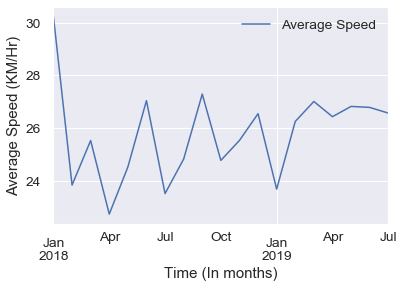

In [17]:
## Remove warning label that would be shown, as the graph is. // get y axis to be in km/hr and add label
import warnings
warnings.simplefilter(action='ignore')

df6 = df2.resample("M").mean()
df6['Time'] = df4.index

df6.plot(x='Time', y='Average Speed')
plt.ylabel("Average Speed (KM/Hr)")
plt.xlabel("Time (In months)")
plt.show()

The average speed for the entire data set has a consitently concise range, with it being spread over 30km at the maximum and approximately 23.4 at the minimum. It can be observed from april onwards, that there is a pattern of high speed for one month, then a lower speed for the next month which is peculiar, as it occurs not as a direct result of seasonal change. This dramatic reccuring change could be the result of an unknown variable, such as races that occur every two months which cause the average to rise significantly.